[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/casangi/astrohack/blob/main/docs/locit_tutorial.ipynb)

![astrohack](_media/astrohack_logo.png)

In [1]:
import os

from importlib.metadata import version

try:
    import astrohack
    
    print('AstroHACK version', version('astrohack'), 'already installed.')
except ImportError as e:
    print(e)
    print('Installing AstroHACK')
    
    os.system("pip install astrohack")
    
    import astrohack 
    print('astrohack version', version('astrohack'), ' installed.')

AstroHACK version 0.3.2 already installed.


# `locit` VLA tutorial

`extract_locit` and `locit` are utilities designed to help determine antenna position shifts after antenna relocation.
To do so they rely on a phase gain calibration table created by `CASA` from antenna pointing data.
The process in `CASA` consists of:
1. `split` out the actual pointing data from the original pointing measurement set (MS), it might contain data taken while the antennas are still slewing.
2. `fringe_fit` the MS using a single source with no delay rates, this is done to flatten a spectral window.
3. `apply_cal` the fringe_fit solution.
4. Channel average the MS using `split`.
5. Compute an average phase gain solution for each source using `gaincal`

To simplify the process in `CASA` a script is distributed within `astrohack` that the user can simply fill in the parameters for the data reduction and then run it within `CASA`.


## Download Tutorial data

In [2]:
# The Cal table used here is a place holder, there should be a better dataset to be used with the tutorial
astrohack.data.datasets.download('locit-input-pha.cal', folder='data')

data/locit-input-pha.cal.zip: 100%|████████| 90.1k/90.1k [00:00<00:00, 878kiB/s]


## Position and locit Data File API

As part of the `astroHACK` API a set of functions to allow users to easily open on disk locit and position files has been provided. Each function takes an `astroHACK` locit or position file name as an argument and returns an object related to the given file type. Each object allows the user to access data via dictionary keys with values consisting of the relevant dataset. Each object also provides a `summary()` helper function to list available keys for each file. An example call for each file type is show below and the API documentation for all data-io functions can be found [here](https://astrohack.readthedocs.io/en/latest/_api/autoapi/astrohack/dio/index.html).

```python
from astrohack.dio import open_locit
from astrohack.dio import open_position

locit_data = open_holog(file='./data/locit-input-pha.locit.zarr')
position_data = open_image(file='./data/locit-input-pha.position.zarr')
```

# Setup Dask Local Cluster

The local Dask client handles scheduling and worker managment for the parallelization. The user has the option of choosing the number of cores and memory allocations for each worker howerver, we recommend a minimum of 1Gb per core with standard settings.


A significant amount of information related to the client and scheduling can be found using the [Dask Dashboard](https://docs.dask.org/en/stable/dashboard.html). This is a built in dashboard native to Dask and allows the user to monitor the workers during processing. This is especially useful for profilling. For those that are interested in working soley within Jupyterlab a dashboard extension is available for [Jupyterlab](https://github.com/dask/dask-labextension#dask-jupyterlab-extension).

![dashboard](_media/dashboard.png)

In [3]:
from astrohack.client import astrohack_local_client

client = astrohack_local_client(cores=4, memory_limit='1GB')
client

2023-10-23 11:06:47,124 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_to_term to True.
2023-10-23 11:06:47,125 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_to_file to False.
2023-10-23 11:06:47,125 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_file to hack_.
2023-10-23 11:06:47,126 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_level to INFO.
2023-10-23 11:06:47,126 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_to_term to False.
2023-10-23 11:06:47,126 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_to_file to False.
2023-10-23 11:06:47,127 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_file to hack_.
2023-10-23 11:06:47,127 - INFO     - astrohack - (_

/export/home/figs/vdesouza/mambaforge/envs/casadev/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35409 instead
  warnings.warn(


2023-10-23 11:06:49,392 - INFO     - astrohack - (client.py:158) - Created client <Client: 'tcp://127.0.0.1:37349' processes=4 threads=4, memory=3.73 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35409/status,
Dashboard: http://127.0.0.1:35409/status,Workers: 4
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37349,Workers: 4
Dashboard: http://127.0.0.1:35409/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:40955,Total threads: 1
Dashboard: http://127.0.0.1:43715/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:34195,


## Extract locit

The first step in determining the antenna position corrections is to extract the data from the phase gains calibration table and store it in a convenient format for further processing.

In the calibration table the data is organized by time, but we want organized by antenna -> DDI -> time for simplicity of processing in `locit`.

Also the data in the calibration table may contain more than one reference antenna, which would scramble the results obtained by `locit`, hence we throw away data that has a different reference antenna than the main reference antenna in `extract_locit`

In [4]:
cal_table = './data/locit-input-pha.cal'
locit_name = './data/locit-input-pha.locit.zarr'
position_name = './data/locit-input-pha.position.zarr'

In [5]:
%%time
from astrohack.extract_locit import extract_locit
locit_mds = extract_locit(cal_table,               # The calibration table containing the phase gains
                          locit_name=locit_name,   # The name for the created locit file
                          ant_id=None,             # Antenna selection, None means 'All'
                          ddi=None,                # DDI selection, None means 'ALL'
                          overwrite=True)

2023-10-23 11:06:49,436 - INFO     - astrohack - (_check_parms.py:135) - [extract_locit]: Setting default ant to all.
2023-10-23 11:06:49,438 - INFO     - astrohack - (_check_parms.py:135) - [extract_locit]: Setting default ddi to all.
2023-10-23 11:06:51,133 - INFO     - astrohack - (extract_locit.py:64) - [extract_locit]: Finished processing
CPU times: user 1.85 s, sys: 129 ms, total: 1.98 s
Wall time: 2 s


`extract_locit` creates a file that is called a locit file. This file contains the phase gains for each antenna but also contains two important tables, the source and antenna tables.

`extract_locit` also returns the opened locit file as a `locit_mds` object. The first step in interacting with the `locit_mds` object is calling its summary

In [6]:
locit_mds.summary()

####################################################################################################
###                                         Summary for:                                         ###
###                              ./data/locit-input-pha.locit.zarr                               ###
####################################################################################################

Input Parameters:
+------------+-----------------------------------+
| Parameter  | Value                             |
+------------+-----------------------------------+
| cal_table  | ./data/locit-input-pha.cal        |
| locit_name | ./data/locit-input-pha.locit.zarr |
| ant_id     | None                              |
| ddi        | all                               |
| overwrite  | True                              |
| ant        | all                               |
| version    | 0.3.2                             |
| origin     | extract_locit                     |
+------------+--

From the summary, we can see that the locit file contains 26 antennas and 2 DDIs per antenna, as well as 4 different methods related to the visualization of the source and antenna tables. To inspect the data contained in a DDI for an antenna, we simply access the dictionary keys as so,

In [7]:
locit_mds['ant_ea06']['ddi_0']

<xarray.Dataset>
Dimensions:         (p0_time: 33, p1_time: 34)
Coordinates:
  * p0_time         (p0_time) float64 6.018e+04 6.018e+04 ... 6.018e+04
  * p1_time         (p1_time) float64 6.018e+04 6.018e+04 ... 6.018e+04
Data variables:
    P0_FIELD_ID     (p0_time) int32 dask.array<chunksize=(33,), meta=np.ndarray>
    P0_PHASE_GAINS  (p0_time) float32 dask.array<chunksize=(33,), meta=np.ndarray>
    P1_FIELD_ID     (p1_time) int32 dask.array<chunksize=(34,), meta=np.ndarray>
    P1_PHASE_GAINS  (p1_time) float32 dask.array<chunksize=(34,), meta=np.ndarray>
Attributes:
    bandwidth:            [128000000.0]
    frequency:            8223000000.0
    polarization_scheme:  ['R', 'L']

### Inspecting the Sources in the dataset

When trying to determine the antenna position correction, we are always interested in knowing the distribution in the sky of the sources used in the pointing observation. The antenna position corrections in X and Y are affected by the hour-angle coverage of the observations, while the Z position correction is affected by the declination coverage of the observations.

First we will print the source table, and second we will plot the sources on a simplified sky plot for easier visualization.

In [8]:
locit_mds.print_source_table()


Sources:
+----+----------+---------------+----------------+---------------+----------------+
| Id | Name     | RA FK5        | DEC FK5        | RA precessed  | DEC precessed  |
+----+----------+---------------+----------------+---------------+----------------+
| 0  | 2023+544 | 20h23m55.833s | +54°27m35.789s | 20h23m21.769s | +54°32m16.844s |
| 1  | 2005+778 | 20h05m30.999s | +77°52m43.247s | 20h03m29.593s | +77°56m51.192s |
| 2  | 0841+708 | 08h41m24.365s | +70°53m42.174s | 08h42m30.408s | +70°48m38.004s |
| 3  | 1419+543 | 14h19m46.597s | +54°23m14.787s | 14h19m21.177s | +54°17m02.436s |
| 4  | 1549+506 | 15h49m17.469s | +50°38m05.788s | 15h48m45.517s | +50°34m04.200s |
| 5  | 1734+389 | 17h34m20.579s | +38°57m51.443s | 17h33m56.032s | +38°57m07.858s |
| 6  | 2052+365 | 20h52m52.050s | +36°35m35.309s | 20h52m36.284s | +36°41m01.557s |
| 7  | 2236+284 | 22h36m22.471s | +28°28m57.413s | 22h36m17.552s | +28°36m19.785s |
| 8  | 1824+107 | 18h24m02.855s | +10°44m23.774s | 18h23m57.669s |

2023-10-23 11:06:51,489 - INFO     - astrohack - (_check_parms.py:135) - [plot_source_positions]: Setting default label to False.


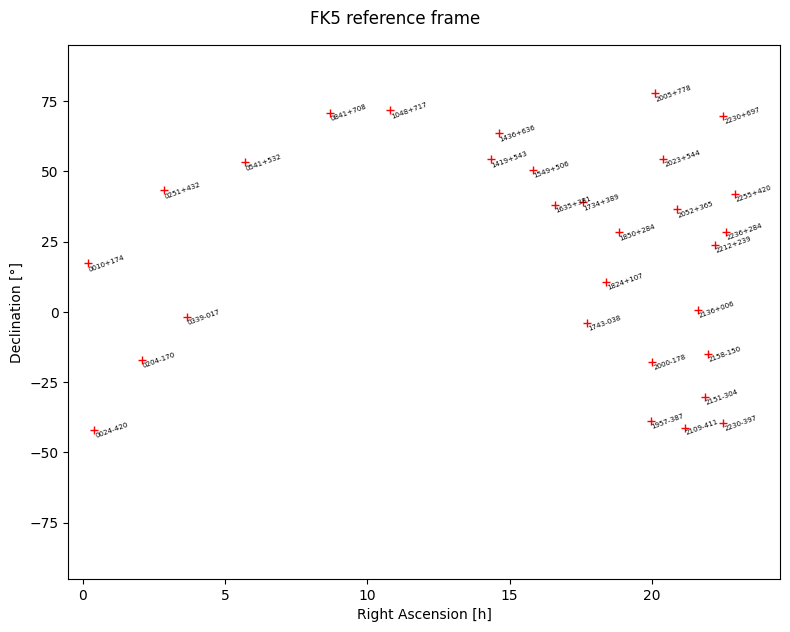

In [9]:
locit_plot_folder = 'locit_mds_plots'
locit_mds.plot_source_positions(locit_plot_folder,   # destination for the plot
                                display_labels=True, # Display source labels on plot
                                precessed=False,     # Plot FK5 (J2000) coordinates instead of prcessed coordinates
                                display=True)

### Inspecting the array configuration in the dataset

Another important piece of information when determining antenna position corrections is which antennas are present in the observations and where are they located in the array. We have introduced two methods to display this information, the first, `print_array_configuration`, displays all the antennas for the array, accompanied by their positions if they are present in the dataset. The second method, `plot_array_configuration`, plots the positions of the antennas in the dataset; antennas not present are simply skipped.

In [10]:
locit_mds.print_array_configuration(relative=False) # antenna positions printed are relative to the array center


EVLA antennas, # of antennas 26:
+------------+---------+-----------------+----------------+--------------+
|    Name    | Station |    Longitude    |    Latitude    |  Radius [m]  |
+------------+---------+-----------------+----------------+--------------+
|    ea01    |   W32   | -107°39m54.777s | +33°52m27.200s | 6373591.7591 |
|    ea02    |   N72   | -107°38m10.526s | +34°04m12.216s | 6373536.5113 |
|    ea03    |   N/A   |       N/A       |      N/A       |     N/A      |
|    ea04    |   E48   | -107°30m56.082s | +33°51m38.381s | 6373617.9185 |
|    ea05    |   W40   | -107°41m13.482s | +33°51m43.069s | 6373588.2127 |
|    ea06    |   MAS   | -107°37m41.283s | +33°53m41.999s | 6373580.9899 |
|    ea07    |   E16   | -107°36m09.822s | +33°53m40.005s | 6373579.2062 |
|    ea08    |   N56   | -107°37m47.893s | +34°00m38.380s | 6373545.7480 |
|    ea09    |   W24   | -107°38m49.036s | +33°53m04.046s | 6373590.5071 |
|    ea10    |   N40   | -107°37m29.504s | +33°57m44.409s | 637355

2023-10-23 11:06:52,047 - INFO     - astrohack - (_check_parms.py:135) - [plot_array_configuration]: Setting default stations to False.
2023-10-23 11:06:52,047 - INFO     - astrohack - (_check_parms.py:135) - [plot_array_configuration]: Setting default zoff to False.
2023-10-23 11:06:52,056 - WARNING  - astrohack - (_dio.py:329) - [plot_array_configuration]: Destination folder already exists, results may be overwritten


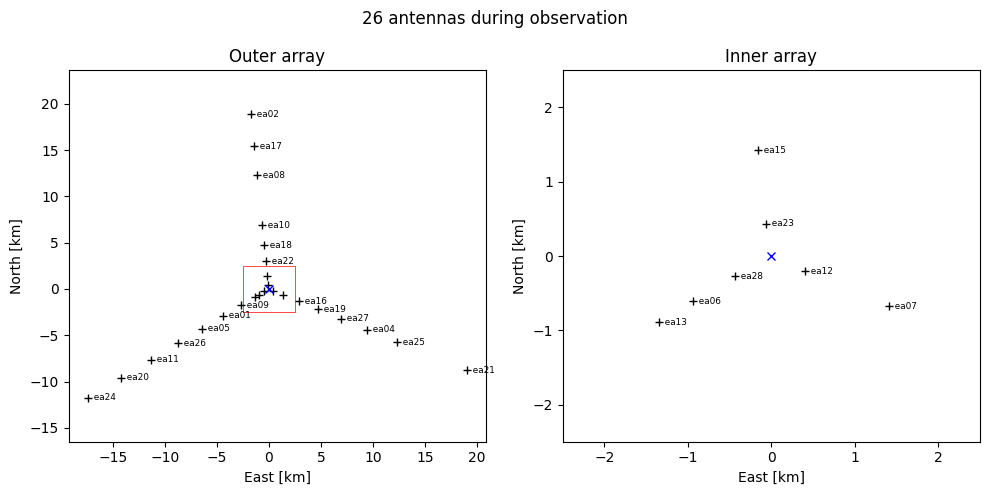

In [11]:
locit_mds.plot_array_configuration(locit_plot_folder,     # Folder in which to save the plot
                                   display_stations=True, # Toggle to display the station name alongside the antenna name
                                   display_zoff=False,    # Toggle to display the antenna elevation offset by its name
                                   unit='km',             # Length unit for the plot
                                   box_size=5,            # Size of the box for the inner array in the unit specified in unit
                                   display=True)

## Locit

After we have inspected the `locit_mds` object we can now use `locit` to obtain antenna position corrections. In this dataset a single antenna, ea06 has been moved, and hence we could skip the other antennas and get position corrections for only it and the reference antenna, ea28. 
But here we will be getting corrections for all antennas as this can help point out systematic errors with the dataset, such as choosing a bad reference antenna.
We include the reference antenna in the fit as a sanity check, the position corrections for the reference antenna, as well as the fixed delay and delay rate are by construction, 0, if they aren't there is something wrong with the code.

In [12]:
%%time
from astrohack.locit import locit
position_mds = locit(locit_name,                    # Name of the locit file on disk
                     position_name=position_name,   # Name of the position file to be created by locit
                     elevation_limit=10.0,          # Elevation under which no sources are considered
                     polarization='both',           # Combine both R and L polarization phase gains for increased SNR
                     fit_engine='scipy',            # Fit data using scipy
                     fit_kterm=False,               # do not fit antenna elevation axis offset term 
                     fit_delay_rate=True,           # Fit delay rate
                     ant_id=None,                   # Select all antennas                   
                     ddi=None,                      # Select all DDIs
                     combine_ddis='simple',         # Combine delays from all DDIs to obtain a single solution with increased SNR
                     parallel=True,                 # Do fitting in parallel
                     overwrite=True)                # Overwrite previously created position file

2023-10-23 11:06:52,769 - INFO     - astrohack - (_check_parms.py:135) - [locit]: Setting default fit_rate to True.
2023-10-23 11:06:52,771 - INFO     - astrohack - (_check_parms.py:135) - [locit]: Setting default ant to all.
2023-10-23 11:06:52,771 - INFO     - astrohack - (_check_parms.py:135) - [locit]: Setting default ddi to all.
2023-10-23 11:06:55,177 - INFO     - astrohack - (locit.py:138) - [locit]: Finished processing
CPU times: user 1.23 s, sys: 43.9 ms, total: 1.28 s
Wall time: 2.56 s


`locit` creates a file that is called a position file. This file contains the delays, and the fitted delay model for each antenna

`locit` also returns the opened position file as a `position_mds` object. The first step in interacting with the `position_mds` object is calling its summary

In [13]:
position_mds.summary()

####################################################################################################
###                                         Summary for:                                         ###
###                             ./data/locit-input-pha.position.zarr                             ###
####################################################################################################

Input Parameters:
+-----------------+--------------------------------------+
| Parameter       | Value                                |
+-----------------+--------------------------------------+
| locit_name      | ./data/locit-input-pha.locit.zarr    |
| position_name   | ./data/locit-input-pha.position.zarr |
| elevation_limit | 10.0                                 |
| polarization    | both                                 |
| fit_engine      | scipy                                |
| fit_kterm       | False                                |
| fit_delay_rate  | True                      

From the summary we can see that the position file contains simply 2 antennas and no DDIs, as well as 4 different methods:
- `export_fit_results` exports the antenna position corrections to an ascii file.
- `plot_sky_coverage` plots the sky coverage for an antenna and DDI (if present).
- `plot_delays` plots the measured delays as a function of time, hour angle, declination and elevation,
- `plot_position_corrections` Plots the position corrections on an array plot, making it easier to identify systematics

To inspect the data contained in the position file for an antenna we can then simply do:

In [14]:
position_mds['ant_ea06']

<xarray.Dataset>
Dimensions:      (time: 110)
Coordinates:
  * time         (time) float64 0.0 0.002234 0.004711 ... 0.07838 0.07992
Data variables:
    DECLINATION  (time) float64 dask.array<chunksize=(110,), meta=np.ndarray>
    DELAYS       (time) float32 dask.array<chunksize=(110,), meta=np.ndarray>
    ELEVATION    (time) float64 dask.array<chunksize=(110,), meta=np.ndarray>
    HOUR_ANGLE   (time) float64 dask.array<chunksize=(110,), meta=np.ndarray>
    LST          (time) float64 dask.array<chunksize=(110,), meta=np.ndarray>
    MODEL        (time) float64 dask.array<chunksize=(110,), meta=np.ndarray>
Attributes:
    antenna_info:       {'geocentric_position': [-1602152.0314, -5042031.7101...
    chi_squared:        3.431397072612707e-23
    elevation_limit:    0.17453292519943295
    fixed_delay_error:  4.550873123481639e-24
    fixed_delay_fit:    2.5331243788995185e-11
    frequency:          [8223000000.0, 8823000000.0]
    polarization:       both
    position_error:     [3.0725952532831997e-24, 1.9854960052318403e-24, 2.40...
    position_fit:       [-2.9894521475528193e-11, -1.225892549558795e-11, -5....
    rate_error:         7.623612582881219e-22
    rate_fit:           8.518928443796131e-12

The following plot of the sky coverage of the sources for antenna ea06 gives us an idea of how good our results can be. From it we see that basically all possible hour-angles and declinations are covered, which implies that the position correction determinations are as good as they can be given the observing conditions are good and stable enough.

Weather may complicate this measurement by introducing anisotropic and time dependant delays, limiting the methods accuracy.

2023-10-23 11:06:55,387 - INFO     - astrohack - (_check_parms.py:135) - [plot_sky_coverage]: Setting default ddi to all.


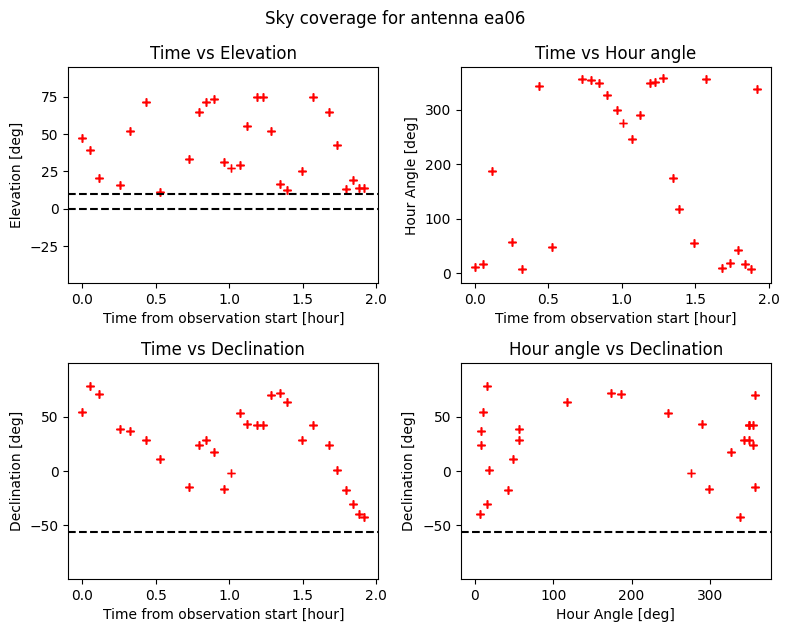

In [15]:
position_plot_folder = 'position_mds_exports'
position_mds.plot_sky_coverage(position_plot_folder, # Folder to contain plot
                               ant_id='ea06',        # Plot only antenna ea06
                               ddi=None,             # DDI selection irrelevant because we are combining DDIs     
                               time_unit='hour',     # Unit for observation duration
                               angle_unit='deg',     # Unit for sky coordinates
                               display=True)

Below we export the fit results to an ascii file and display it for analysis.
In it we can see that the results for the reference antenna are all 0 and the delay RMS is very small, which is indeed what is expected.

Further, below we plot the delays and the delay model that was fitted with `locit`. From this plot we can see that model delays agree very well with the observed delays leading to a good confidence in the position corrections derived with `locit`.

In [16]:
position_export_folder = 'position_mds_exports'
position_mds.export_fit_results(position_export_folder,           # Folder to contain antenna position corrections file  
                                ant_id = ['ea06', 'ea28','ea01'], # select antennas ea06, ea28 and ea01
                                position_unit='m',                # Unit for the position corrections
                                delay_unit='nsec',                # Unit for delays
                                time_unit='hour')                 # Unit for delay rate denominator

2023-10-23 11:06:56,473 - INFO     - astrohack - (_check_parms.py:135) - [export_fit_results]: Setting default ddi to all.
2023-10-23 11:06:56,483 - WARNING  - astrohack - (_dio.py:329) - [export_fit_results]: Destination folder already exists, results may be overwritten


In [17]:
with open(position_export_folder+'/position_combined_simple_fit_results.txt', 'r') as file:
    for line in file:
        print(line[:-1])

+---------+------------+-----------------+----------------+--------------+---------------+------------------+
| Antenna | RMS [nsec] | F. delay [nsec] |  X offset [m]  | Y offset [m] |  Z offset [m] | Rate [nsec/hour] |
+---------+------------+-----------------+----------------+--------------+---------------+------------------+
|   ea01  |  1.57e-02  |   0.015 ± 0.0   | 0.00055 ± 0.0  | 0.0055 ± 0.0 | -0.0016 ± 0.0 |    0.0 ± 0.0     |
|   ea06  |  5.86e-03  |   0.025 ± 0.0   | -0.00079 ± 0.0 | 0.0097 ± 0.0 | -0.0015 ± 0.0 |  0.00035 ± 0.0   |
|   ea28  |  5.94e-11  |    0.0 ± 0.0    |   0.0 ± 0.0    |  0.0 ± 0.0   |   0.0 ± 0.0   |    0.0 ± 0.0     |
+---------+------------+-----------------+----------------+--------------+---------------+------------------+


2023-10-23 11:06:56,505 - INFO     - astrohack - (_check_parms.py:135) - [plot_delays]: Setting default ddi to all.
2023-10-23 11:06:56,506 - INFO     - astrohack - (_check_parms.py:135) - [plot_delays]: Setting default plot_fit to True.
2023-10-23 11:06:56,515 - WARNING  - astrohack - (_dio.py:329) - [plot_delays]: Destination folder already exists, results may be overwritten


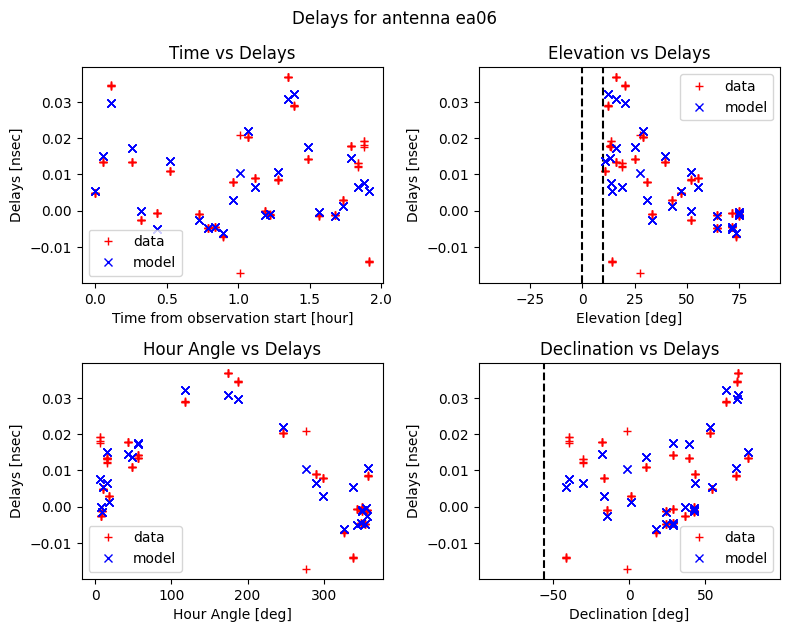

In [18]:
position_mds.plot_delays(position_plot_folder, # Folder to contain plot
                         ant_id='ea06',         # Plot only antenna ea06
                         ddi=None,              # DDI selection irrelevant because we are combining DDIs
                         time_unit='hour',      # Unit for observation duration
                         angle_unit='deg',      # Unit for sky coordinates
                         delay_unit='nsec',     # Unit for delays
                         plot_model=True,       # Plot fitted delay model
                         display=True)

One extra way to check for systematic errors in antenna position determinations is to plot the corrections for the whole array.
If all the corrections point the same way this might be an indication that the chosen reference_antenna has an error in its position.

2023-10-23 11:06:57,798 - INFO     - astrohack - (_check_parms.py:135) - [plot_position_corrections]: Setting default stations to False.
2023-10-23 11:06:57,799 - INFO     - astrohack - (_check_parms.py:135) - [plot_position_corrections]: Setting default ant to all.
2023-10-23 11:06:57,801 - INFO     - astrohack - (_check_parms.py:135) - [plot_position_corrections]: Setting default ddi to all.
2023-10-23 11:06:57,811 - WARNING  - astrohack - (_dio.py:329) - [plot_position_corrections]: Destination folder already exists, results may be overwritten


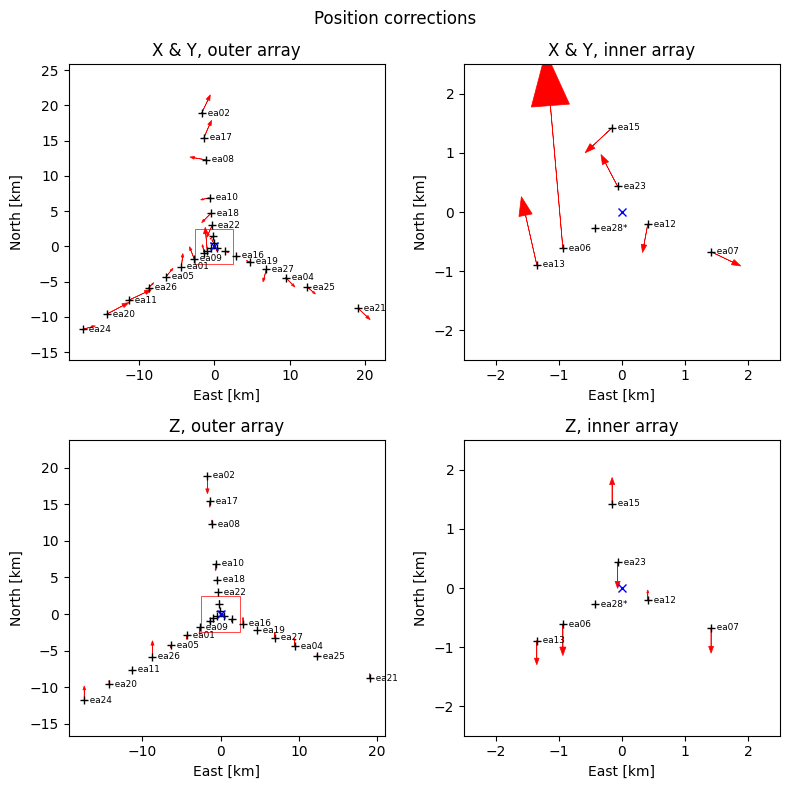

In [19]:
position_mds.plot_position_corrections(position_plot_folder, # Folder to contain plot
                                       unit='km',            # Unit for the x and Y axes
                                       box_size=5,           # Size for the box containing the inner array
                                       scaling=250,          # scaling to be applied to corrections
                                       display=True)